# Multi-objective Robust Optimization (MORO)


This exercise demostrates the application of MORO on the lake model. In contrast to the exercises in previous weeks, we will be using a slightly more sophisticated version of the problem. For details see the MORDM assignment for this week.

## Setup MORO

Many objective robust optimization aims at finding decisions that are robust with respect to the various deeply uncertain factors. For this, MORO evalues each candidate decision over a set of scenarios. For each outcome of interest, the robusntess over this set is calculated. A MOEA is used to maximize the robustness. 

For this assignment, we will be using a domain criterion as our robustness metric. The table below lists the rules that you should use for each outcome of interest.

|Outcome of interest| threhsold  |
|-------------------|------------|
| Maximum pollution | $\leq$ 0.75|
| Inertia           | $\geq$ 0.6 |
| Reliability       | $\geq$ 0.99|   
| Utility           | $\geq$ 0.75|

**1) Implement a function for each outcome that takes a numpy array with results for the outcome of interest, and returns the robustness score**

In [1]:
# Importing the relevant libraries

from dps_lake_model import lake_model
from ema_workbench import (RealParameter, ScalarOutcome, Constant,
                           Model, MultiprocessingEvaluator, SequentialEvaluator, ema_logging,
                           perform_experiments, Policy)
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench.em_framework.samplers import sample_uncertainties
from lakemodel_function import lake_problem
from ema_workbench.analysis import prim
from SALib.analyze import sobol

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Defining robustness metrics for each kpi

import functools
import numpy as np
from dps_lake_model import lake_model

def robustness(direction, threshold, data):
    if direction == SMALLER:
        return np.sum(data<=threshold)/data.shape[0]
    else:
        return np.sum(data>=threshold)/data.shape[0]

# def maxp(data):
#     return np.sum(data<=0.75)/data.shape[0]
    
SMALLER = 'SMALLER'
LARGER = 'LARGER'

maxp = functools.partial(robustness, SMALLER, 0.75)
inertia = functools.partial(robustness, LARGER, 0.6)
reliability = functools.partial(robustness, LARGER, 0.99)
utility = functools.partial(robustness, LARGER, 0.75)

maxp(np.array([0.1]))



1.0

In [43]:
# Attatching the model to the workbench

lake_model = Model('Lakemodel', function=lake_model)

lake_model.uncertainties = [RealParameter('b',0.1,0.45),
                           RealParameter('q',2.0,4.5),
                           RealParameter('mean',0.01,0.05),
                           RealParameter('stdev',0.001,0.005),
                           RealParameter('delta',0.93,0.99)]

lake_model.levers = [RealParameter('c1',-2.0,2.0),
                           RealParameter('c2',-2.0,2.0),
                           RealParameter('r1',0.0,2.0),
                           RealParameter('r2',0.0,2.0),
                           RealParameter('w1',0.0,1.0)]

lake_model.outcomes = [ScalarOutcome('max_P', kind=ScalarOutcome.MINIMIZE, expected_range=(0,5)),
                  ScalarOutcome('utility', kind=ScalarOutcome.MAXIMIZE, expected_range=(0,2)),
                  ScalarOutcome('intertia', kind=ScalarOutcome.MAXIMIZE, expected_range=(0,1)),
                  ScalarOutcome('reliability', kind=ScalarOutcome.MAXIMIZE, expected_range=(0,1))]

**2) Generate 4 random release policies, and evaluate them over 500 scenarios. Sample the scenarios using Monte Carlo sampling. Next evaulate your robustness function for 1, 2, 3, ... 500 scenarios for each outcome and visualize this. What can you tell about the convergernce of the robusntess metric as a function of the number of scenarios?**

First of, we will try and run the model with 500 scenarios and 4 random polcicies. We will use monte carlo sampling.

In [44]:
ema_logging.log_to_stderr(ema_logging.INFO)
with MultiprocessingEvaluator(lake_model) as evaluator:
    experiment, result = evaluator.perform_experiments(
                                         scenarios=500,
                                         policies = 4, 
                                         uncertainty_sampling='mc')

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 500 scenarios * 4 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [54]:
# Save the policies so we can later use them again!
policies = experiment.groupby('policy').mean()
policies = policies[['c1', 'c2', 'r1', 'r2', 'w1']]
policies

,c1,c2,r1,r2,w1
policy,,,,,
0,-1.158246,-0.419446,1.520198,0.953444,0.198371
1,-0.320766,1.050577,1.009775,1.633716,0.876989
2,1.672276,0.382179,0.946574,1.071976,0.564566
3,0.331633,-1.164746,0.159149,0.148028,0.347339


In [55]:
policies_list1 = [Policy(str(index), **row.to_dict()) for index, row in policies.iterrows()]
policies_list1

[Policy({'c1': -1.15824617658739, 'c2': -0.41944626234391025, 'r1': 1.5201980735405123, 'r2': 0.9534444382547357, 'w1': 0.1983708039619677}),
 Policy({'c1': -0.32076590298345303, 'c2': 1.0505771803659594, 'r1': 1.009775413549153, 'r2': 1.633715620747914, 'w1': 0.8769887704759023}),
 Policy({'c1': 1.672276348203923, 'c2': 0.38217923047652874, 'r1': 0.9465736270212678, 'r2': 1.0719758514484394, 'w1': 0.5645661146515036}),
 Policy({'c1': 0.33163316026164574, 'c2': -1.164745679566976, 'r1': 0.1591488395797626, 'r2': 0.14802772214992538, 'w1': 0.34733859402049966})]

In [56]:
# Making a function that easily describes the robustness scores per policy
def calc_robustness(experiment, results):
    df = pd.DataFrame(results)
    data = pd.concat([experiment, df], 1)
    fig, ax = plt.subplots(2,2, figsize=(12,12))
    data.groupby('policy').apply(lambda x: maxp(x.max_P)).plot.bar(ax=ax[0,0], title="maxp")
    data.groupby('policy').apply(lambda x: utility(x.utility)).plot.bar(ax=ax[0,1], title="utility")
    data.groupby('policy').apply(lambda x: inertia(x.intertia)).plot.bar(ax=ax[1,0], title="inertia")
    data.groupby('policy').apply(lambda x: reliability(x.reliability)).plot.bar(ax=ax[1,1], title="reliability")
    


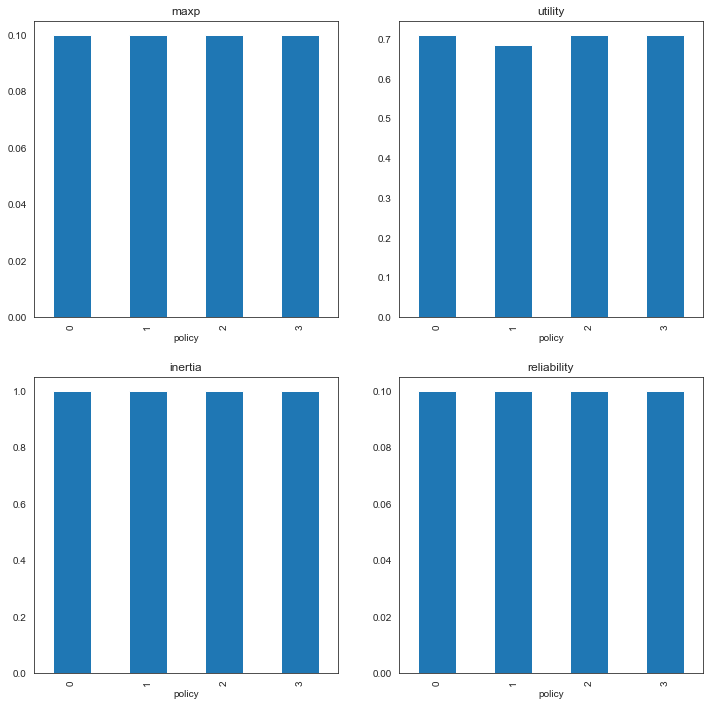

In [57]:
calc_robustness(experiment, result)

In the first run, especially inertia and utility seem really robust. Their robustness doesnt differ that much per policy. The policies score less robust on reliability and maxp, their robustness scores are relativeliy low.

In [58]:
ema_logging.log_to_stderr(ema_logging.INFO)
with MultiprocessingEvaluator(lake_model) as evaluator:
    experiment1, result1 = evaluator.perform_experiments(
                                         scenarios=100,
                                         policies = policies_list1, 
                                         uncertainty_sampling='mc')

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 100 scenarios * 4 policies * 1 model(s) = 400 experiments
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 80 cases completed
[MainProcess/INFO] 120 cases completed
[MainProcess/INFO] 160 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 240 cases completed
[MainProcess/INFO] 280 cases completed
[MainProcess/INFO] 320 cases completed
[MainProcess/INFO] 360 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


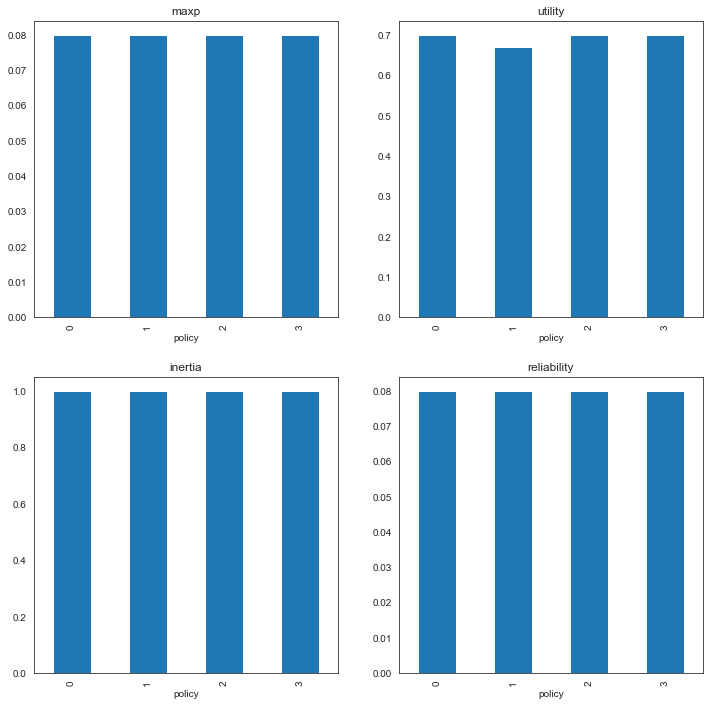

In [59]:
calc_robustness(experiment1, result1)

With less scenarios and the same policies, the robustness scores on reliability and maxp are a little lower. However, on average the scores are pretty much the same in comparison to the 500 scenarios analysis. 

In [60]:
ema_logging.log_to_stderr(ema_logging.INFO)
with MultiprocessingEvaluator(lake_model) as evaluator:
    experiment2, result2 = evaluator.perform_experiments(
                                         scenarios=1000,
                                         policies = policies_list1, 
                                         uncertainty_sampling='mc')

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 4 policies * 1 model(s) = 4000 experiments
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3200 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


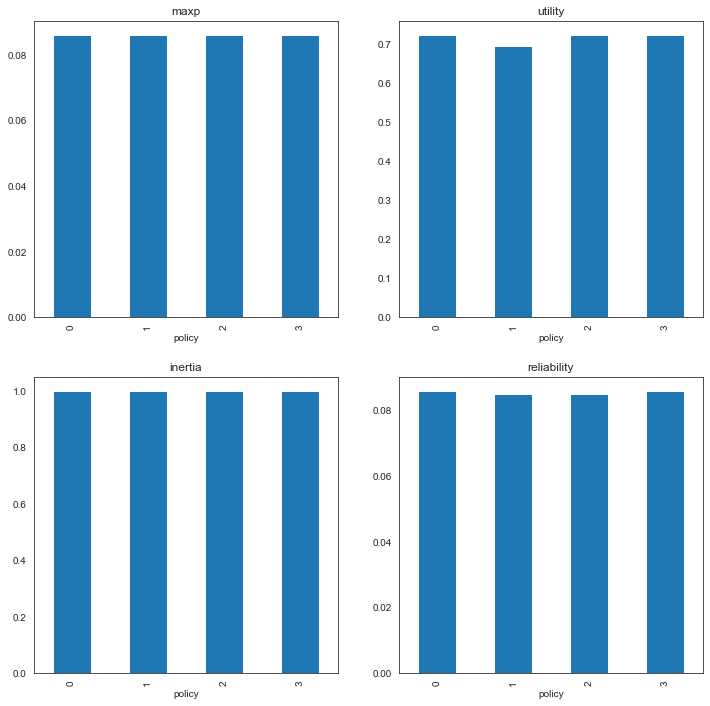

In [61]:
calc_robustness(experiment2, result2)

We increased the amount of scenarios to 1000 per policy and this resulted in pretty much the same robustness scores in comparioson to the other analysis. 

## Searching for candidate solutions
Set up the robust optimization problem using the robustness functions you have specified. Assume that you will need 50 scenarios for estimating the robustness. Use $\epsilon$-progress and hypervolume to track convergence. Solve the optimization problem. As $\epsilon$ values, you can assume 0.05 for each of the four robustness metrics.

*note: this optimization problem is computationally very expensive. Develop and test your code using a sequential evaluator, a low number of function evaluations (e.g., 200), and a low number of scenarios (e.g., 5). Once everything seems to be working replace the sequential evaluator with an multiprocessing or ipyparallel evaluator, and increase the number of nfe and scenarios*.


In [17]:
from ema_workbench.em_framework.optimization import (HyperVolume,
                                                     EpsilonProgress)
from ema_workbench import Constraint

In [18]:
# Defining the robustness functions
robust = [ScalarOutcome('Fmax_P', kind=ScalarOutcome.MAXIMIZE, variable_name='max_P', function=maxp),
          ScalarOutcome('Futility', kind=ScalarOutcome.MAXIMIZE,variable_name='utility',  function=utility),
          ScalarOutcome('Fintertia', kind=ScalarOutcome.MAXIMIZE, variable_name='intertia', function=inertia),
          ScalarOutcome('Freliability', kind=ScalarOutcome.MAXIMIZE, variable_name='reliability', function=reliability)]

In [19]:
convergence_metrics = [HyperVolume.from_outcomes(lake_model.outcomes),
                       EpsilonProgress()]

In [8]:
type(lake_model)

ema_workbench.em_framework.model.Model

In [20]:
scenarios = sample_uncertainties(lake_model, 50)

In [21]:
ema_logging.log_to_stderr(ema_logging.INFO)
with MultiprocessingEvaluator(lake_model) as evaluator:
    robust_results, convergence = evaluator.robust_optimize(robust, 
                                                    scenarios=scenarios,
                                                    nfe = 200,
                                                    epsilons=[0.05, 0.05, 0.05, 0.05],
                                                    convergence=convergence_metrics)


[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/200 nfe
[MainProcess/INFO] optimization completed, found 7 solutions
[MainProcess/INFO] terminating pool


In [22]:
robust_results

,c1,c2,r1,r2,w1,Fmax_P,Futility,Fintertia,Freliability
0,-0.342288,1.777549,0.232772,1.280989,0.455637,0.08,0.72,1.0,0.08
1,0.509916,0.462178,1.039880,0.378625,0.002785,0.58,0.48,1.0,0.58
2,0.449409,0.701958,0.340975,0.369954,0.545999,0.26,0.66,1.0,0.26
3,0.449409,0.619184,0.340975,0.369954,0.545999,0.48,0.54,1.0,0.48
4,0.449409,0.677611,0.340975,0.422976,0.545999,0.34,0.62,1.0,0.34
5,0.317244,0.771562,0.311932,1.452100,0.757073,0.66,0.34,1.0,0.64
6,0.319364,0.700377,0.320284,1.452100,0.757073,0.68,0.24,1.0,0.66


The algorithm found 7 optimal solutions. The policies related to these solutions are shown in the above dataframe.

In [25]:
convergence

,hypervolume,epsilon_progress,nfe
0,0.000000,0,0
1,0.020394,6,100


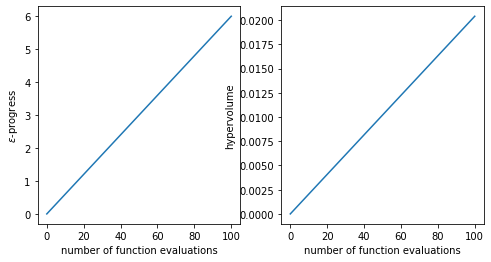

In [26]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence.nfe, convergence.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence.nfe, convergence.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

We simulated not that much runs, so the convergence is not yet optimal. In optimal situations, you want to increase the nfe. However, due to time constraints and computational limitations we will not do this. 

**Plot your $\epsilon$-progress to evaluate convergergence, and visualize the trade-offs using parallel coordinate plots**

In [29]:
outcomes = robust_results.loc[:,['Fmax_P', 'Futility', 'Fintertia', 'Freliability']]

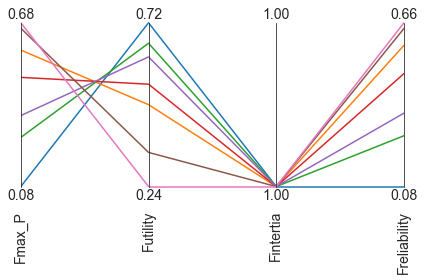

In [30]:
from ema_workbench.analysis import parcoords

limits = parcoords.get_limits(outcomes)
axes = parcoords.ParallelAxes(limits)
axes.plot(outcomes)
plt.show()

**What does this plot tell us about the tradeoffs and conflicting objectives?**

The desired robustness score of inertia can always be achieved, no matter what one wants on the other objectives. However, the other kpis have tradeoffs. A policy can't score robust on all metrics, so one should either chose to make their policy robust on reliability and maxp or on utility for example. The tradeofss are visualized in the plot above.

## Re-evaluate candidate solutions under uncertainty

We have used only 50 scenarios for the optimization. Take the results and re-evaluate them over a larger set (assume 1000 scenarios). How different are your results? What does this imply for the assumption of 50 scenarios during robust optimization.

*hint: use the to_dict method on a dataframe, next generate Policy objects in a list expression by iterating over the dicts returned by the to_dict method*

In [31]:
results1 = robust_results


In [32]:
results1

,c1,c2,r1,r2,w1,Fmax_P,Futility,Fintertia,Freliability
0,-0.342288,1.777549,0.232772,1.280989,0.455637,0.08,0.72,1.0,0.08
1,0.509916,0.462178,1.039880,0.378625,0.002785,0.58,0.48,1.0,0.58
2,0.449409,0.701958,0.340975,0.369954,0.545999,0.26,0.66,1.0,0.26
3,0.449409,0.619184,0.340975,0.369954,0.545999,0.48,0.54,1.0,0.48
4,0.449409,0.677611,0.340975,0.422976,0.545999,0.34,0.62,1.0,0.34
5,0.317244,0.771562,0.311932,1.452100,0.757073,0.66,0.34,1.0,0.64
6,0.319364,0.700377,0.320284,1.452100,0.757073,0.68,0.24,1.0,0.66


In [33]:
policies = results1[['c1', 'c2', 'r1', 'r2', 'w1']]
policies_list = [Policy(str(index), **row.to_dict()) for index, row in policies.iterrows()]
policies_list


[Policy({'c1': -0.3422878651454222, 'c2': 1.7775488383835363, 'r1': 0.2327721777249725, 'r2': 1.2809885415945614, 'w1': 0.45563675921170677}),
 Policy({'c1': 0.5099158747907699, 'c2': 0.4621777954474702, 'r1': 1.0398800948507307, 'r2': 0.37862518619872976, 'w1': 0.0027852090103972493}),
 Policy({'c1': 0.4494086989741665, 'c2': 0.7019575039653313, 'r1': 0.34097525383810234, 'r2': 0.36995435820912204, 'w1': 0.5459991512063218}),
 Policy({'c1': 0.4494086989741665, 'c2': 0.6191843498849647, 'r1': 0.34097525383810234, 'r2': 0.36995435820912204, 'w1': 0.5459991512063218}),
 Policy({'c1': 0.4494086989741665, 'c2': 0.6776107976318032, 'r1': 0.34097525383810234, 'r2': 0.4229764564795444, 'w1': 0.5459991512063218}),
 Policy({'c1': 0.31724386736099175, 'c2': 0.771561665493396, 'r1': 0.31193162888056625, 'r2': 1.4520996526587577, 'w1': 0.7570733992799774}),
 Policy({'c1': 0.31936431934798293, 'c2': 0.7003767983557587, 'r1': 0.3202838531362895, 'r2': 1.4520996526587577, 'w1': 0.7570733992799774})]

In [34]:
ema_logging.log_to_stderr(ema_logging.INFO)
with MultiprocessingEvaluator(lake_model) as evaluator:
    experiment_robust_2, result_robust_2 = evaluator.perform_experiments(
                                         scenarios=1000,
                                         policies = policies_list, 
                                         uncertainty_sampling='mc')

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 7 policies * 1 model(s) = 7000 experiments
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2800 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] 4200 cases completed
[MainProcess/INFO] 4900 cases completed
[MainProcess/INFO] 5600 cases completed
[MainProcess/INFO] 6300 cases completed
[MainProcess/INFO] 7000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


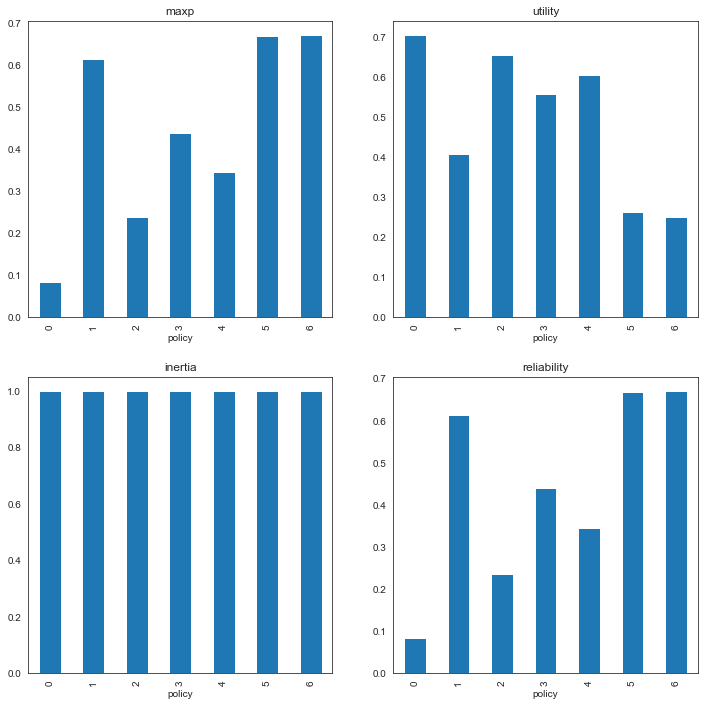

In [35]:
calc_robustness(experiment_robust_2, result_robust_2)

In [39]:
def prepair_data(experiment, results):
    df = pd.DataFrame(results)
    data = pd.concat([experiment, df], 1)
    results_p = pd.DataFrame()
    results_p['maxp'] = data.groupby('policy').apply(lambda x: maxp(x.max_P))
    results_p['utility'] = data.groupby('policy').apply(lambda x: utility(x.utility))
    results_p['intertia'] = data.groupby('policy').apply(lambda x: inertia(x.intertia))
    results_p['reliability'] = data.groupby('policy').apply(lambda x: reliability(x.reliability))
    
    return results_p
da = prepair_data(experiment_robust_2, result_robust_2)

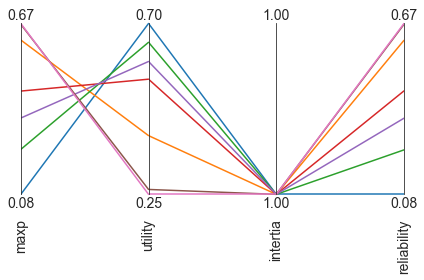

In [40]:
limits = parcoords.get_limits(da)
axes = parcoords.ParallelAxes(limits)
axes.plot(da)
plt.show()

The results seem to be very similair. Both 1000 scenarios and 50 have the same robustness scores as optimal results. So it seems that the assumption of 50 scenarios for the optimalisation is okay.

## Comparison
If you have time, import your solutions found for MORDM and re-evaluate them over the same set of scnearios as used for re-evaluating the MORO results. Compare the robustness of MORDM and MORO, what do you observe?

As of today, we don't have enough time for this comparison.   